In [244]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [245]:
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
from pylab import *
import os
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4)})
plotStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
np.seterr(divide='ignore',invalid='ignore')
pass

# Setup the notebook.

In [246]:
import h5py
import math
import random
testNames=[
        "reflecting_global",
        ]
test_names_bash_list=" ".join(testNames)

In [247]:
%%bash
rm -rf tmp && mkdir tmp

In [248]:
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [249]:
def buildPartitionedLattice(filename):
    fp = h5py.File(filename, "a")
    sites=fp["/Model/Diffusion/LatticeSites"]
    sites[0:5,:,:] = 0
    sites[5,:,:] = 2
    sites[6:11,:,:] = 1
    initialCounts=fp["/Model/Reaction/InitialSpeciesCounts"]
    particles=fp["/Model/Diffusion/Lattice"]
    for i in range(len(initialCounts)):
        attempts = 0
        placed = 0
        while placed < initialCounts[i]:
            attempts += 1
            x = random.randint(0,particles.shape[0]-1)
            y = random.randint(0,particles.shape[1]-1)
            z = random.randint(0,particles.shape[2]-1)
            if (i == 0 and sites[x,y,z] == 0 and x == 0) or (i == 1 and sites[x,y,z] == 1 and x == 10) or (i == 2 and sites[x,y,z] == 2):
                for p in range(particles.shape[3]):
                    if particles[x,y,z,p] == 0xFF:
                        particles[x,y,z,p] = i
                        placed += 1
                        break
        print "Placed %d particles of type %d in %d attempts."%(placed,i,attempts)
    fp.close()   

# Execute the simulations.

In [250]:
%%bash -s "$test_names_bash_list"
sbmlFilename="diffusion_model.sbml"
for testName in $1; do
    outputFilename=tmp/${testName}.lm
    rm -f ${outputFilename}*
    lm_sbml_import ${outputFilename} ${sbmlFilename} > ${outputFilename}.import.log
    if [[ ${testName} == reflecting_* ]]; then
        lm_setdm ${outputFilename} PlaceParticles=0 numberReactions=0 numberSpecies=3 numberSiteTypes=3 "latticeSize=[11,11,11]" latticeSpacing=1e-6 particlesPerSite=16 "DiffusionMatrix(:,:,0)=[1e-10,0,1e-10;0,0,0;1e-10,0,1e-10;]" "DiffusionMatrix(:,:,1)=[0,0,0;0,1e-10,1e-10;0,1e-10,1e-10]" "DiffusionMatrix(:,:,2)=[1e-10,0,0;0,1e-10,0;1e-11,1e-12,1e-10]" "ReactionLocationMatrix=[]" > ${outputFilename}.setdm.log
        lm_setp ${outputFilename} maxTime=1e0 writeInterval=1e-1 latticeWriteInterval=1e-1 > /dev/null
        bc=REFLECTING
    elif [[ ${testName} == absorbing_* ]]; then
        lm_setdm ${outputFilename} PlaceParticles=0 numberReactions=0 numberSpecies=16 numberSiteTypes=1 "latticeSize=[51,51,51]" latticeSpacing=1e-6 particlesPerSite=16 "DiffusionMatrix(:,:,:)=[1e-10]" "ReactionLocationMatrix=[]" > ${outputFilename}.setdm.log
        lm_setp ${outputFilename} maxTime=2e0 writeInterval=1e-1 latticeWriteInterval=1e-1 > /dev/null
        bc=ABSORBING
    elif [[ ${testName} == periodic_* ]]; then
        lm_setdm ${outputFilename} PlaceParticles=0 numberReactions=0 numberSpecies=16 numberSiteTypes=1 "latticeSize=[21,21,21]" latticeSpacing=1e-6 particlesPerSite=16 "DiffusionMatrix(:,:,:)=[1e-10]" "ReactionLocationMatrix=[]" > ${outputFilename}.setdm.log
        lm_setp ${outputFilename} maxTime=2e0 writeInterval=1e-2 latticeWriteInterval=1e-2 > /dev/null
        bc=PERIODIC
    else
        echo "Invalid test name: ${testName}"
        continue
    fi
    if [[ ${testName} == *_global ]]; then
        lm_setp ${outputFilename} boundaryConditions=${bc} > /dev/null
    elif [[ ${testName} == *_x ]]; then
        lm_setp ${outputFilename} boundaryConditions=x:${bc},y:REFLECTING,z:REFLECTING > /dev/null
    elif [[ ${testName} == *_y ]]; then
        lm_setp ${outputFilename} boundaryConditions=x:REFLECTING,y:${bc},z:REFLECTING > /dev/null
    elif [[ ${testName} == *_z ]]; then
        lm_setp ${outputFilename} boundaryConditions=x:REFLECTING,y:REFLECTING,z:${bc} > /dev/null
    else
        echo "Invalid test name: ${testName}"
        continue
    fi
done;
echo "Finished."

Finished.


In [251]:
# Construct the lattices.
for testName in testNames:
    buildPartitionedLattice("tmp/%s.lm"%(testName))
print "Finished."

Placed 100 particles of type 0 in 964 attempts.
Placed 200 particles of type 1 in 2203 attempts.
Placed 300 particles of type 2 in 3254 attempts.
Finished.


In [252]:
%%bash -s "$test_names_bash_list"
for testName in $1; do
    outputFilename=tmp/${testName}.lm
    lmes -sp -r 1-10 -f ${outputFilename} > ${outputFilename}.simulate.log
done;
echo "Finished."

Finished.


# Spot check some simulations.

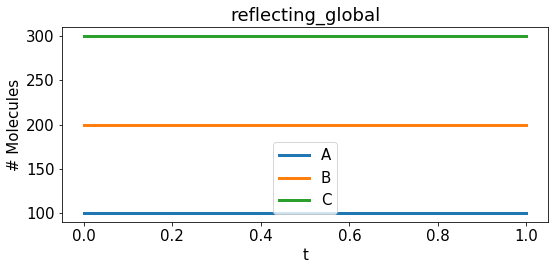

In [253]:
# Plot the time series for a single replicate.
for i,testName in enumerate(testNames):
    testOutputFilename="tmp/%s.lm"%(testName)
    fp = h5py.File(testOutputFilename, "r")
    cols=2
    rows=len(testNames)//cols
    if rows*cols < len(testNames): rows += 1
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,4*rows)})
    for replicate in (1,):
        counts=np.array(fp["/Simulations/%07d/SpeciesCounts"%replicate], dtype=double)
        times=np.array(fp["/Simulations/%07d/SpeciesCountTimes"%replicate], dtype=double)
        plt.subplot(rows,cols,i+1)
        plot(times,counts[:,0], label='A', **plotStyles)
        plot(times,counts[:,1], label='B', **plotStyles)
        plot(times,counts[:,2], label='C', **plotStyles)
        xlabel('t'); ylabel('# Molecules'); title("%s"%(testName)); legend()
    fp.close()
plt.tight_layout()
pass

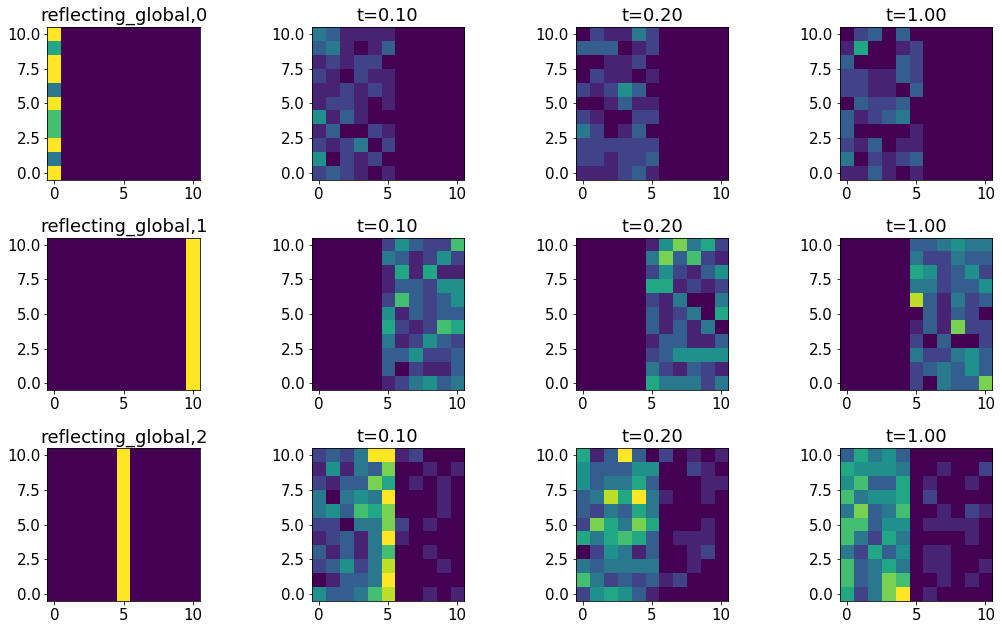

In [254]:
# Plot the time series for a single replicate.
rows=len(testNames)*3
cols=4
for i,testName in enumerate(testNames):
    testOutputFilename="tmp/%s.lm"%(testName)
    fp = h5py.File(testOutputFilename, "r")
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,3*rows)})
    replicate=1
    lattices=fp["/Simulations/%07d/Lattice"%replicate].keys()
    times=fp["/Simulations/%07d/LatticeTimes"%replicate]
    latticeIndices=(0,1,2,len(lattices)-1)
    for j in range(len(latticeIndices)):
        lfull = np.array(fp["/Simulations/%07d/Lattice/%s"%(replicate,lattices[latticeIndices[j]])], dtype=np.uint8)
        for k in range(3):
            lc = np.sum(lfull==k,3)
            plt.subplot(rows,cols,(i*3+k)*cols+j+1)
            plt.imshow(np.sum(lc[:,:,:],2).T, origin='lower', interpolation="none", vmin=0.0, vmax=10.0)
            if j == 0:
                title("%s,%d"%(testName,k))
            else:
                title("t=%0.2f"%times[latticeIndices[j]])
    fp.close()
plt.tight_layout()
pass

# Define some tests.

In [269]:
def test_reflecting(testOutputFilename):
    
    # Compare the species and lattice output.
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    for replicate in replicates:
        times = np.array(fp["/Simulations/%s/SpeciesCountTimes"%replicate], dtype=double)
        latticeTimes = np.array(fp["/Simulations/%s/LatticeTimes"%replicate], dtype=double)
        if not np.array_equal(times.shape, latticeTimes.shape): raise Exception("time and lattice time not equal for replicate",replicate)
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        latticeNames = fp["/Simulations/%s/Lattice"%replicate].keys()
        if counts.shape[0] != len(latticeNames): raise Exception("number of counts and lattices not equal for replicate",replicate)
        ti=0
        for latticeName in latticeNames:
            lattice = np.array(fp["/Simulations/%s/Lattice/%s"%(replicate,latticeName)], dtype=np.uint8)
            for p in range(counts.shape[1]):
                latticeCount = np.sum(lattice==p)
                if counts[ti,p] != latticeCount: raise Exception("counts and lattice counts not equal for replicate and time",replicate,latticeName)
            ti+=1
        
        # Check that we aren't losing particles.
        for i in range(times.shape[0]):
            if np.sum(counts[i,]) != np.sum(counts[0,]): raise Exception("invalid number of particles at time %d and replicate %s"%(times[i],replicate))

    # Calculate the density profile vs time.
    density = None
    for replicate in replicates:
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        latticeTimes = np.array(fp["/Simulations/%s/LatticeTimes"%replicate], dtype=double)
        latticeNames = fp["/Simulations/%s/Lattice"%replicate].keys()
        for ti,latticeName in enumerate(latticeNames):
            lattice = np.array(fp["/Simulations/%s/Lattice/%s"%(replicate,latticeName)], dtype=np.uint8)
            if density is None: density = np.zeros((latticeTimes.shape[0],lattice.shape[0],counts.shape[1]), dtype=float)
            for p in range(counts.shape[1]):
                density[ti,:,p] += np.sum(np.sum(np.sum(lattice==p,3),2),1)
    density /= len(replicates)
    density[:,:,0] /= 100
    density[:,:,1] /= 200
    density[:,:,2] /= 300
    
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,3)})
    plt.subplot(1,3,1)
    plt.plot(range(density.shape[1]), density[0,:,0], **plotStyles)
    plt.plot(range(density.shape[1]), density[density.shape[0]//2,:,0], **plotStyles)
    plt.plot(range(density.shape[1]), density[-1,:,0], **plotStyles)
    xlabel("X"); ylabel("Density"); title("A")
    plt.subplot(1,3,2)
    plt.plot(range(density.shape[1]), density[0,:,1], **plotStyles)
    plt.plot(range(density.shape[1]), density[density.shape[0]//2,:,1], **plotStyles)
    plt.plot(range(density.shape[1]), density[-1,:,1], **plotStyles)
    xlabel("X"); ylabel("Density"); title("B")
    plt.subplot(1,3,3)
    plt.plot(range(density.shape[1]), density[0,:,2], **plotStyles)
    plt.plot(range(density.shape[1]), density[density.shape[0]//2,:,2], **plotStyles)
    plt.plot(range(density.shape[1]), density[-1,:,2], **plotStyles)
    xlabel("X"); ylabel("Density"); title("A")
    
    
    # Check the density at the beginning.
    if not isclose(density[0,0,0],1.0,1e-6): raise Exception("invalid density for 0 at %0.3e %d %d"%(times[0],0,0))
    for i in range(1,density.shape[2]):
        if not isclose(density[0,i,0],0.0,1e-6): raise Exception("invalid density for 0 at %0.3e %d %d"%(times[0],i,0))
    if not isclose(density[0,-1,1],1.0,1e-6): raise Exception("invalid density for 1 at %0.3e %d %d"%(times[0],0,0))
    for i in range(0,density.shape[2]-1):
        if not isclose(density[0,i,1],0.0,1e-6): raise Exception("invalid density for 1 at %0.3e %d %d"%(times[0],i,0))
    if not isclose(density[0,density.shape[1]//2,2],1.0,1e-6): raise Exception("invalid density for 2 at %0.3e %d %d"%(times[0],0,0))
    for i in range(0,density.shape[1]//2):
        if not isclose(density[0,i,2],0.0,1e-6): raise Exception("invalid density for 2 at %0.3e %d %d"%(times[0],i,0))
    for i in range(density.shape[1]//2+1,density.shape[1]):
        if not isclose(density[0,i,2],0.0,1e-6): raise Exception("invalid density for 2 at %0.3e %d %d"%(times[0],i,0))
            
    # Check the density at the end.
    for i in range(0,6):
        if not isclose(density[-1,i,0],0.16,0.25): raise Exception("invalid density for 0 at %0.3e %d %d: %0.3e"%(times[-1],i,0,density[-1,i,0]))
    for i in range(6,density.shape[1]):
        if not isclose(density[-1,i,0],0.0,0.25): raise Exception("invalid density for 0 at %0.3e %d %d: %0.3e"%(times[-1],i,0,density[-1,i,0]))

    for i in range(0,5):
        if not isclose(density[-1,i,1],0.0,0.25): raise Exception("invalid density for 1 at %0.3e %d %d: %0.3e"%(times[-1],i,0,density[-1,i,1]))
    for i in range(5,density.shape[1]):
        if not isclose(density[-1,i,1],0.16,0.25): raise Exception("invalid density for 1 at %0.3e %d %d: %0.3e"%(times[-1],i,0,density[-1,i,1]))
        
    for i in range(0,5):
        if not isclose(density[-1,i,2],0.18,0.25): raise Exception("invalid density for 2 at %0.3e %d %d: %0.3e"%(times[-1],i,0,density[-1,i,2]))
    if not isclose(density[-1,5,2],0.0,0.25): raise Exception("invalid density for 2 at %0.3e %d %d: %0.3e"%(times[-1],i,0,density[-1,5,2]))
    for i in range(6,density.shape[1]):
        if not isclose(density[-1,i,2],0.02,0.25): raise Exception("invalid density for 2 at %0.3e %d %d: %0.3e"%(times[-1],i,0,density[-1,i,2]))
        
#     for k in range(3):
#             plt.subplot(rows,cols,(i*3+k)*cols+j+1)
#             plt.imshow(np.sum(lc[:,:,:],2).T, origin='lower', interpolation="none", vmin=0.0, vmax=10.0)
#             if j == 0:
#                 title("%s,%d"%(testName,k))
#             else:
#                 title("t=%0.2f"%times[latticeIndices[j]])
    
    
#     msd=None
#     valuesAdded=0
#         origin = np.zeros((counts.shape[1],3))
#         if msd is None:
#             msd = np.zeros((counts.shape[0],3))
#                 pos = np.where(lattice==p)
#                 pos = (pos[0][0],pos[1][0],pos[2][0])
#                 if ti == 0: origin[p,:] = pos
#                 msd[ti,:] += (pos-origin[p])**2
#     msd /= len(replicates)*counts.shape[1]
#     msd_theory = 2*1e-10*1e12*latticeTimes
#     matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,5)})
#     plt.subplot(2,3,1)
#     plt.plot(latticeTimes, msd[:,0], 'bx')
#     plt.plot(latticeTimes, msd_theory, 'r-')
#     xlabel("t"); ylabel("MSD ($\mu$m)"); title("x")
#     plt.subplot(2,3,2)
#     plt.plot(latticeTimes, msd[:,1], 'bx')
#     plt.plot(latticeTimes, msd_theory, 'r-')
#     xlabel("t"); ylabel("MSD ($\mu$m)"); title("y")
#     plt.subplot(2,3,3)
#     plt.plot(latticeTimes, msd[:,2], 'bx')
#     plt.plot(latticeTimes, msd_theory, 'r-')
#     xlabel("t"); ylabel("MSD ($\mu$m)"); title("z")
#     plt.subplot(2,3,4)
#     plt.plot(latticeTimes, abs(msd[:,0]-msd_theory)/msd_theory, 'b')
#     xlabel("t"); ylabel("Error"); yscale('log');
#     plt.subplot(2,3,5)
#     plt.plot(latticeTimes, abs(msd[:,1]-msd_theory)/msd_theory, 'b')
#     xlabel("t"); ylabel("Error"); yscale('log');
#     plt.subplot(2,3,6)
#     plt.plot(latticeTimes, abs(msd[:,2]-msd_theory)/msd_theory, 'b')
#     xlabel("t"); ylabel("Error"); yscale('log');
    
#     for i in range(1,6):
#         if not isclose(msd[i,0],msd_theory[i],2.5e-1): raise Exception("incorrect value for x msd at t=%0.3e msd=%0.3e theory=%0.3e"%(latticeTimes[i],msd[i,0],msd_theory[i]))
#         if not isclose(msd[i,0],msd_theory[i],2.5e-1): raise Exception("incorrect value for y msd at t=%0.3e msd=%0.3e theory=%0.3e"%(latticeTimes[i],msd[i,1],msd_theory[i]))
#         if not isclose(msd[i,0],msd_theory[i],2.5e-1): raise Exception("incorrect value for z msd at t=%0.3e msd=%0.3e theory=%0.3e"%(latticeTimes[i],msd[i,2],msd_theory[i]))

# Run the tests.

[reflecting_global:test_reflecting]                          : passed.


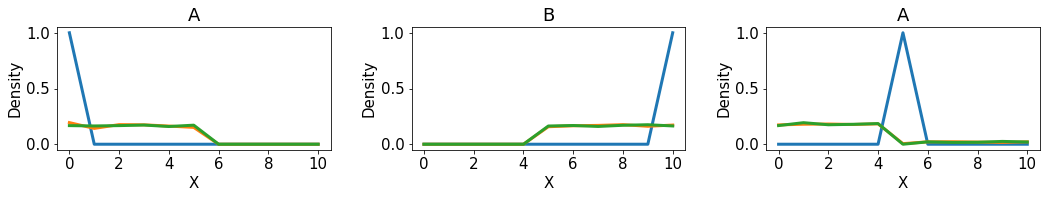

In [270]:
testMethods = {
    "reflecting_global": [test_reflecting],
}

matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (20,5)})
i=1
for testName in testNames:
    for i,testMethod in enumerate(testMethods[testName]):
        try:
            testOutputFilename="tmp/%s.lm"%(testName)
            testMethod(testOutputFilename)
        except Exception as e:
            print "%-60s : FAILED with:"%("["+testName+":"+testMethod.__name__+"]"),e
        except:
            print "%-60s : FAILED with: Unknown exception"%("["+testName+":"+testMethod.__name__+"]")
        else:
            print "%-60s : passed."%("["+testName+":"+testMethod.__name__+"]")
        plt.tight_layout()
        plt.show()
pass

In [271]:
%%bash
rm -rf tmp